In [1]:
import http.client
import json

connection = http.client.HTTPConnection('api.football-data.org')
headers = { 'X-Auth-Token': '4ba22c664da84bd4a8d6fe0cf2e9f312', 'X-Response-Control': 'minified' }
connection.request('GET', '/v1/competitions/445/fixtures', None, headers )
response = json.loads(connection.getresponse().read().decode())

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from football_sim import *
import os

In [3]:
data=pd.DataFrame()
for _match in response['fixtures']:
    if _match['status']=='FINISHED':
        data=add_match(data,_match['homeTeamName'],_match['result']['goalsHomeTeam'],_match['awayTeamName'],_match['result']['goalsAwayTeam'],the_date=pd.to_datetime(_match['date']))

In [4]:
calibrator=Calibrator('calibration_other_source.pkl')
calibrator.process_data(data,'EN')
teams=calibrator.teams

calibration_other_source.pkl  exists.
file exists, loading
333


In [5]:
Teams=dict()
League=dict()

In [6]:
country='EN'
home_advantage=np.array(calibrator.teams['Home'+country].means())-np.array(calibrator.teams['Away'+country].means())
print(home_advantage)
Teams[country]={x:teams[x] for x in teams if teams[x].country==country}
League[country]=Season(Teams[country],home_advantage=home_advantage)
League[country].process_current_results(data)
League[country].simulate_season(n_scenarios=100000)
League[country].season_report()

[ 0.19496266 -0.19466874]
simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Manchester City FC,100.4,97,102,1,1,100.0,100.00,2.33,0.14,0.00
Manchester United FC,81.6,77,86,4,2,0.0,99.96,1.39,0.14,0.00
Liverpool FC,79.3,76,82,4,2,0.0,99.88,1.75,0.16,0.00
Tottenham Hotspur FC,78.4,74,82,4,2,0.0,99.60,1.45,0.13,0.00
Chelsea FC,68.7,64,73,6,5,0.0,0.56,1.14,0.23,0.00
Arsenal FC,62.4,58,67,7,5,0.0,0.00,1.32,0.54,0.00
Burnley FC,59.8,56,64,7,6,0.0,0.00,0.49,0.16,0.00
Leicester City FC,50.6,46,55,10,8,0.0,0.00,0.97,0.56,0.00
Everton FC,47.8,43,52,11,8,0.0,0.00,0.61,0.73,0.00
Newcastle United FC,47.0,43,51,11,8,0.0,0.00,0.58,0.46,0.00


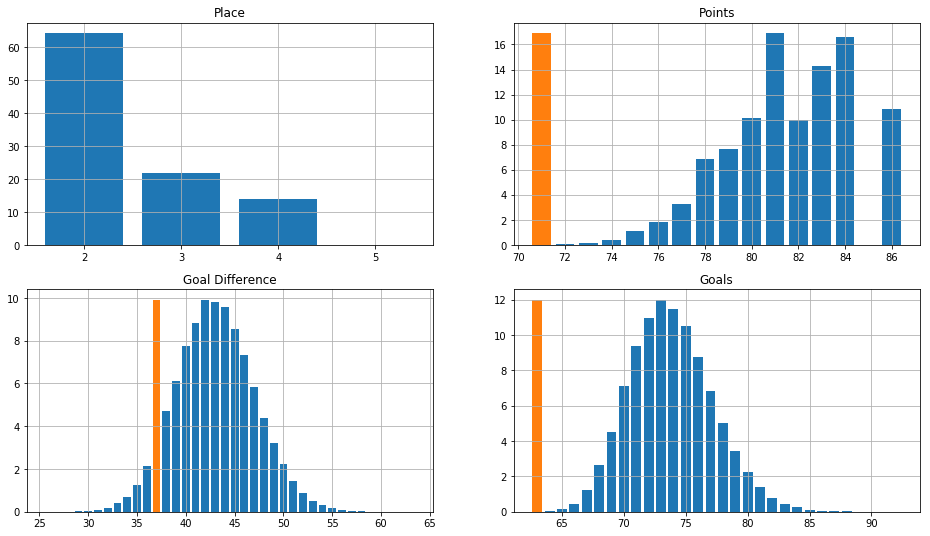

In [7]:
PremierLeague=League['EN']
PremierLeague.team_report('Manchester United FC')

array([99.963     , 99.99601424, 99.78234846, 99.9099273 ])

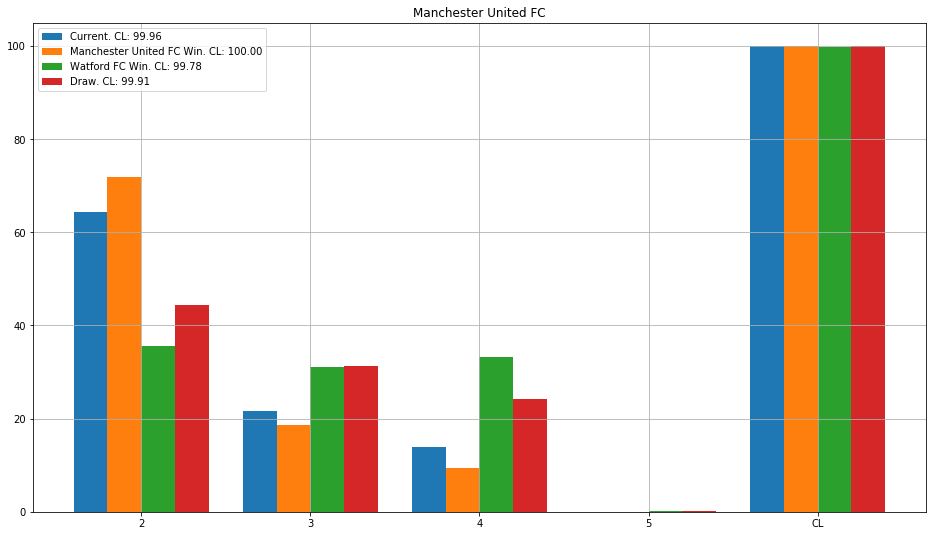

In [8]:
imp=[]
ref_team='Manchester United FC'
#ref_team='Liverpool'
#ref_team='Arsenal'
matches=[]
for x in PremierLeague.matches_to_sim:
    matches.append(x)
    pcl=PremierLeague.what_if(x,ref_team=ref_team,show_plot=False,place=2,or_better=True)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
    #imp.append(1/pcl.min())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
PremierLeague.what_if(the_match,ref_team=ref_team)

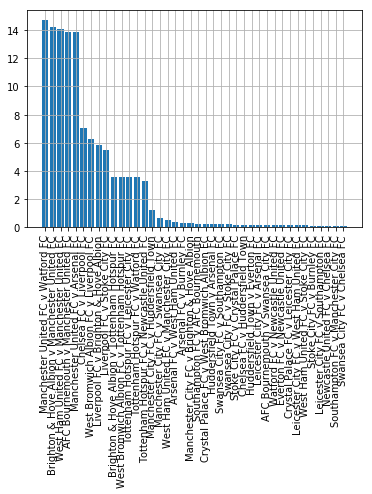

In [9]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(40)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)

2.12651

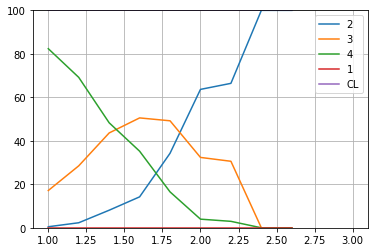

In [10]:
team_name='Manchester United FC'
#team_name='Tottenham'
#team_name='Chelsea'
#team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],6])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
        p[jj,4]=(plc[ind]==1).sum()/ind.sum()
    

plt.plot(nrpnts/n,100*p[:,0],label='2')
plt.plot(nrpnts/n,100*p[:,1],label='3')
plt.plot(nrpnts/n,100*p[:,2],label='4')
plt.plot(nrpnts/n,100*p[:,4],label='1')
plt.plot(nrpnts/n,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
pnts.mean()/n